<a href="https://colab.research.google.com/github/vdelapuentea/PROYECTO-PUCP/blob/main/notebooks/deeplab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorflow==2.9.1

# Importacion de librerias

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical ,Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adadelta, Nadam ,Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard
import tensorflow as tf
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))
from glob import glob
from pathlib import Path
import shutil
from tqdm import tqdm_notebook
from random import sample, choice

import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import OneHotMeanIoU

Versión de tensorflow

In [12]:
tf.__version__

'2.8.2'

# **Lectura de datos** 

Con este código listamos todos los archivos que tenemos en el dataset


In [13]:
dataset_path = Path("/content/drive/MyDrive/PROYECTO-PUCP/data")
list(dataset_path.iterdir())

[PosixPath('/content/drive/MyDrive/PROYECTO-PUCP/data/class_dict.csv'),
 PosixPath('/content/drive/MyDrive/PROYECTO-PUCP/data/val'),
 PosixPath('/content/drive/MyDrive/PROYECTO-PUCP/data/train_labels'),
 PosixPath('/content/drive/MyDrive/PROYECTO-PUCP/data/train'),
 PosixPath('/content/drive/MyDrive/PROYECTO-PUCP/data/val_labels'),
 PosixPath('/content/drive/MyDrive/PROYECTO-PUCP/data/CamVid'),
 PosixPath('/content/drive/MyDrive/PROYECTO-PUCP/data/test_labels'),
 PosixPath('/content/drive/MyDrive/PROYECTO-PUCP/data/test')]

In [16]:
def tree(directory):
    print(f'+ {directory}')
    for path in sorted(directory.rglob('*')):
        depth = len(path.relative_to(directory).parts)
        spacer = '    ' * depth
        print(f'{spacer}+ {path.name}')       
#tree(dataset_path)

In [49]:
def make_prediction(model,img_path,shape):
    img= img_to_array(load_img(img_path , target_size= shape))/255.
    img = np.expand_dims(img,axis=0)
    labels = model.predict(img)
    labels = np.argmax(labels[0],axis=2)
    return labels

In [50]:
def form_colormap(prediction,mapping):
    h,w = prediction.shape
    color_label = np.zeros((h,w,3),dtype=np.uint8)    
    color_label = mapping[prediction]
    color_label = color_label.astype(np.uint8)
    return color_label

Con este código asignamos una variable a cada archivo.




In [17]:
train_imgs = list((dataset_path / "train").glob("*.png"))
train_labels = list((dataset_path / "train_labels").glob("*.png"))
val_imgs = list((dataset_path / "val").glob("*.png"))
val_labels = list((dataset_path / "val_labels").glob("*.png"))
test_imgs = list((dataset_path / "test").glob("*.png"))
test_labels = list((dataset_path / "test_labels").glob("*.png"))

(len(train_imgs),len(train_labels)), (len(val_imgs),len(val_labels)) , (len(test_imgs),len(test_labels))



((421, 421), (112, 112), (168, 168))

# **Configuración de Parametros**


In [28]:
img_size = 128
IMAGE_SIZE = 128
BATCH_SIZE = 4
NUM_CLASSES = 32
NUM_TRAIN_IMAGES = 421
NUM_VAL_IMAGES = 112

In [19]:
assert len(train_imgs) == len(train_labels), "No of Train images and label mismatch"
assert len(val_imgs) == len(val_labels), "No of Train images and label mismatch"
assert len(test_imgs) == len(test_labels), "No of Train images and label mismatch"

sorted(train_imgs), sorted(train_labels), sorted(val_imgs), sorted(val_labels), sorted(test_imgs), sorted(test_labels);

In [20]:
for im in train_imgs:
    assert dataset_path / "train_labels" / (im.stem +"_L.png") in train_labels , "{im} not there in label folder"
for im in val_imgs:
    assert dataset_path / "val_labels" / (im.stem +"_L.png") in val_labels , "{im} not there in label folder"
for im in test_imgs:
    assert dataset_path / "test_labels" / (im.stem +"_L.png") in test_labels , "{im} not there in label folder"

In [21]:
def make_pair(img,label,dataset):
    pairs = []
    for im in img:
        pairs.append((im , dataset / label / (im.stem +"_L.png")))
    
    return pairs

In [22]:
train_pair = make_pair(train_imgs, "train_labels", dataset_path)
val_pair = make_pair(val_imgs, "val_labels", dataset_path)
test_pair = make_pair(test_imgs, "test_labels", dataset_path)

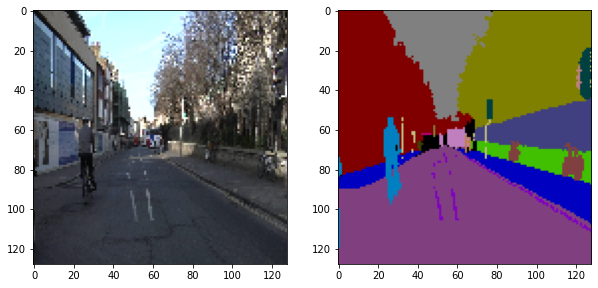

In [29]:
temp = choice(train_pair)
img = img_to_array(load_img(temp[0], target_size=(img_size,img_size)))
mask = img_to_array(load_img(temp[1], target_size = (img_size,img_size)))
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img/255)
plt.subplot(122)
plt.imshow(mask/255)

In [30]:
class_map_df = pd.read_csv(dataset_path / "class_dict.csv")

In [31]:
class_map = []
for index,item in class_map_df.iterrows():
    class_map.append(np.array([item['r'], item['g'], item['b']]))
    
len(class_map)

32

In [32]:
def assert_map_range(mask,class_map):
    mask = mask.astype("uint8")
    for j in range(img_size):
        for k in range(img_size):
            assert mask[j][k] in class_map , tuple(mask[j][k])

In [33]:
def form_2D_label(mask,class_map):
    mask = mask.astype("uint8")
    label = np.zeros(mask.shape[:2],dtype= np.uint8)
    
    for i, rgb in enumerate(class_map):
        label[(mask == rgb).all(axis=2)] = i
    
    return label

In [34]:
lab = form_2D_label(mask,class_map)
np.unique(lab,return_counts=True)

(array([ 1,  2,  4,  7,  8,  9, 10, 12, 14, 16, 17, 19, 20, 21, 24, 26, 27,
        30, 31], dtype=uint8),
 array([   5,  289, 3000,   17,   57,  985,  137,    6,  179,   10, 5296,
         993,   20, 1560,  165, 2979,  100,  137,  449]))

## **Creación de la Clase de DataGenerator**


In [35]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, pair, class_map, batch_size=16, dim=(224,224,3), shuffle=True):
        'Initialization'
        self.dim = dim
        self.pair = pair
        self.class_map = class_map
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.pair) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.pair))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_imgs = list()
        batch_labels = list()

        # Generate data
        for i in list_IDs_temp:
            # Store sample
            img = load_img(self.pair[i][0] ,target_size=self.dim)
            img = img_to_array(img)/255.
            batch_imgs.append(img)

            label = load_img(self.pair[i][1],target_size=self.dim)
            label = img_to_array(label)
            label = form_2D_label(label,self.class_map)
            label = to_categorical(label , num_classes = len(class_map)) #class_map <- parametrizar
            batch_labels.append(label)
            
        return np.array(batch_imgs) ,np.array(batch_labels)

In [36]:
train_generator = DataGenerator(train_pair,class_map,batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)
train_steps = train_generator.__len__()
train_steps

105

In [37]:
x,y = train_generator.__getitem__(0)
x.shape,y.shape

((4, 128, 128, 3), (4, 128, 128, 32))

In [38]:
#+test_pair
test_generator = DataGenerator(test_pair,class_map,batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)
test_generator = train_generator.__len__()
test_generator

105

In [39]:
val_generator = DataGenerator(val_pair, class_map, batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)
val_steps = val_generator.__len__()
val_steps

28

In [40]:
train_dataset = train_generator
val_dataset = val_generator

# **Estructura del la red neuronal DEEPLAB**

In [41]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [42]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization

In [43]:
#from tensorflow.python.keras.utils import metrics_utils

# **Configuración de hiperparametros**


In [44]:
loss = keras.losses.BinaryCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy", tf.keras.metrics.OneHotMeanIoU(num_classes= 32, name=None, dtype=None)]
            ) 

# **Entrenamiento del modelo**

In [45]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=200,
                    callbacks=[EarlyStopping(patience=20)]
                   )

Epoch 1/200
105/105 [==============================] - 217s 2s/step - loss: 0.1149 - accuracy: 0.7121 - one_hot_mean_io_u: 0.1120 - val_loss: 0.1450 - val_accuracy: 0.3454 - val_one_hot_mean_io_u: 0.0267
Epoch 2/200
105/105 [==============================] - 35s 334ms/step - loss: 0.0367 - accuracy: 0.8044 - one_hot_mean_io_u: 0.1693 - val_loss: 0.1665 - val_accuracy: 0.2769 - val_one_hot_mean_io_u: 0.0096
Epoch 3/200
105/105 [==============================] - 34s 320ms/step - loss: 0.0309 - accuracy: 0.8261 - one_hot_mean_io_u: 0.2109 - val_loss: 0.2120 - val_accuracy: 0.3122 - val_one_hot_mean_io_u: 0.0160
Epoch 4/200
105/105 [==============================] - 35s 333ms/step - loss: 0.0270 - accuracy: 0.8435 - one_hot_mean_io_u: 0.2596 - val_loss: 0.2173 - val_accuracy: 0.2801 - val_one_hot_mean_io_u: 0.0191
Epoch 5/200
105/105 [==============================] - 33s 319ms/step - loss: 0.0253 - accuracy: 0.8515 - one_hot_mean_io_u: 0.2953 - val_loss: 0.1857 - val_accuracy: 0.3759 - va

# Guardamos el modelo 

In [46]:
model.save('modelDeepLab.h5')
print('Model Saved!')

Model Saved!


# Cargamos el modelo guardado

In [47]:
savedModel=load_model('modelDeepLab.h5')
#savedModel.summary()

## Comparación de la etiqueta con lo predicho

Text(0.5, 1.0, 'predicted labels')

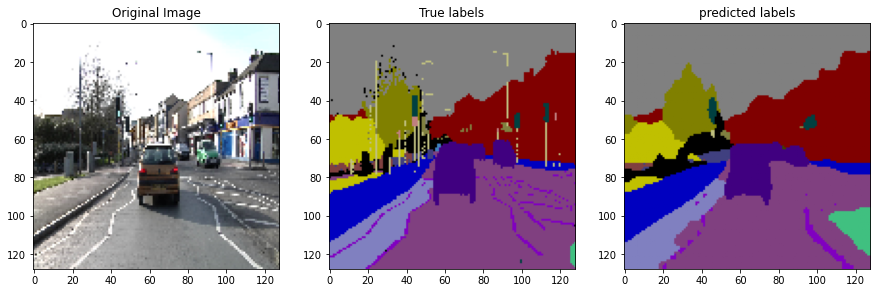

In [51]:
#img_mask = choice(val_pair)
img_mask = (Path('/content/drive/MyDrive/PROYECTO-PUCP/data/val/0016E5_01320.png'),
            Path('/content/drive/MyDrive/PROYECTO-PUCP/data/val_labels/0016E5_01320_L.png'))
img= img_to_array(load_img(img_mask[0] , target_size= (img_size,img_size)))
gt_img = img_to_array(load_img(img_mask[1] , target_size= (img_size,img_size)))

pred_label = make_prediction(savedModel, img_mask[0], (img_size,img_size,3))
pred_colored = form_colormap(pred_label,np.array(class_map))
plt.figure(figsize=(15,15))
plt.subplot(131);plt.title('Original Image')
plt.imshow(img/255.)
plt.subplot(132);plt.title('True labels')
plt.imshow(gt_img/255.)
plt.subplot(133)
plt.imshow(pred_colored/255.);plt.title('predicted labels')

Text(0.5, 1.0, 'predicted labels')

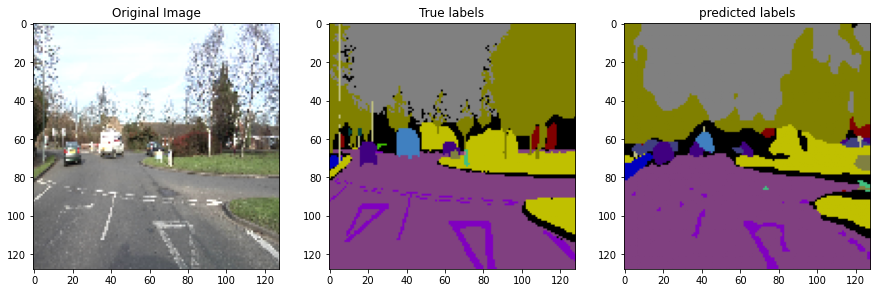

In [52]:
img_mask = (Path('/content/drive/MyDrive/PROYECTO-PUCP/data/val/0006R0_f01050.png'),
            Path('/content/drive/MyDrive/PROYECTO-PUCP/data/val_labels/0006R0_f01050_L.png'))
img= img_to_array(load_img(img_mask[0] , target_size= (img_size,img_size)))
gt_img = img_to_array(load_img(img_mask[1] , target_size= (img_size,img_size)))

pred_label = make_prediction(savedModel, img_mask[0], (img_size,img_size,3))
pred_colored = form_colormap(pred_label,np.array(class_map))
plt.figure(figsize=(15,15))
plt.subplot(131);plt.title('Original Image')
plt.imshow(img/255.)
plt.subplot(132);plt.title('True labels')
plt.imshow(gt_img/255.)
plt.subplot(133)
plt.imshow(pred_colored/255.);plt.title('predicted labels')

Text(0.5, 1.0, 'predicted labels')

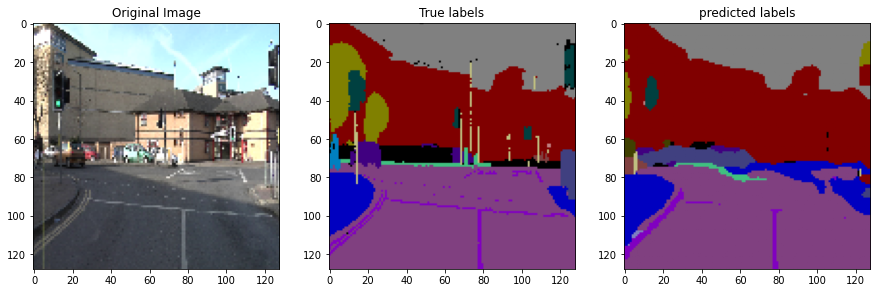

In [53]:
img_mask = (Path('/content/drive/MyDrive/PROYECTO-PUCP/data/val/0016E5_00510.png'),
            Path('/content/drive/MyDrive/PROYECTO-PUCP/data/val_labels/0016E5_00510_L.png'))
img= img_to_array(load_img(img_mask[0] , target_size= (img_size,img_size)))
gt_img = img_to_array(load_img(img_mask[1] , target_size= (img_size,img_size)))

pred_label = make_prediction(savedModel, img_mask[0], (img_size,img_size,3))
pred_colored = form_colormap(pred_label,np.array(class_map))
plt.figure(figsize=(15,15))
plt.subplot(131);plt.title('Original Image')
plt.imshow(img/255.)
plt.subplot(132);plt.title('True labels')
plt.imshow(gt_img/255.)
plt.subplot(133)
plt.imshow(pred_colored/255.);plt.title('predicted labels')